In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import logging
from datetime import datetime, timedelta
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up credentials
credentials = service_account.Credentials.from_service_account_file(
    '/Users/ttanaka/Downloads/predictive-behavior-analytics-b509bad93e58.json'
)

# Set the correct project ID
project_id = "predictive-behavior-analytics"

# Log the project ID being used
logger.info(f"Using project ID: {project_id}")

# Create a BigQuery client
client = bigquery.Client(credentials=credentials, project=project_id)

def fetch_and_process_data(start_date, end_date, chunk_size=7, output_dir='processed_data'):
    """
    Fetch data from BigQuery in chunks, process it, and save to disk.
    
    :param start_date: Start date for data fetch (string in format 'YYYYMMDD')
    :param end_date: End date for data fetch (string in format 'YYYYMMDD')
    :param chunk_size: Number of days to fetch in each chunk
    :param output_dir: Directory to save processed data
    """
    start = datetime.strptime(start_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    
    os.makedirs(output_dir, exist_ok=True)
    
    current_start = start
    chunk_number = 1
    
    while current_start <= end:
        current_end = min(current_start + timedelta(days=chunk_size - 1), end)
        
        query = f"""
        SELECT
          CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
          date,
          totals.timeOnSite,
          totals.pageviews,
          totals.transactions,
          totals.transactionRevenue,
          trafficSource.source,
          trafficSource.medium,
          device.deviceCategory,
          geoNetwork.country,
          hits
        FROM
          `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
          _TABLE_SUFFIX BETWEEN '{current_start.strftime('%Y%m%d')}' AND '{current_end.strftime('%Y%m%d')}'
        """
        
        logger.info(f"Fetching data from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")
        
        df_chunk = client.query(query).to_dataframe()
        logger.info(f"Fetched chunk with shape: {df_chunk.shape}")
        
        # Process the chunk (you can add more processing steps here)
        df_chunk['date'] = pd.to_datetime(df_chunk['date'], format='%Y%m%d')
        
        # Save processed chunk to disk
        output_file = os.path.join(output_dir, f'processed_chunk_{chunk_number}.pkl')
        df_chunk.to_pickle(output_file)
        logger.info(f"Saved processed chunk to {output_file}")
        
        current_start = current_end + timedelta(days=1)
        chunk_number += 1

def load_and_combine_chunks(directory='processed_data'):
    """
    Load processed chunks from disk and combine them.
    
    :param directory: Directory where processed chunks are saved
    :return: Combined DataFrame
    """
    all_chunks = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            chunk = pd.read_pickle(file_path)
            all_chunks.append(chunk)
            logger.info(f"Loaded chunk from {file_path}, shape: {chunk.shape}")
    
    combined_df = pd.concat(all_chunks, ignore_index=True)
    logger.info(f"Combined all chunks. Final shape: {combined_df.shape}")
    return combined_df

# Main execution
if __name__ == "__main__":
    start_date = '20160801'
    end_date = '20170731'
    chunk_size = 7  # Fetch 7 days of data at a time
    
    logger.info("Starting data fetch and processing...")
    fetch_and_process_data(start_date, end_date, chunk_size)
    logger.info("Finished fetching and processing all data.")
    
     # logger.info("Loading and combining all processed chunks...")
    # final_df = load_and_combine_chunks()
    # logger.info(f"Final combined DataFrame shape: {final_df.shape}")

INFO:__main__:Using project ID: predictive-behavior-analytics
INFO:__main__:Starting data fetch and processing...
INFO:__main__:Fetching data from 2016-08-01 to 2016-08-07
I0000 00:00:1724001883.005679 2056990 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
INFO:__main__:Fetched chunk with shape: (15889, 11)
INFO:__main__:Saved processed chunk to processed_data/processed_chunk_1.pkl
INFO:__main__:Fetching data from 2016-08-08 to 2016-08-14
I0000 00:00:1724001899.838423 2056990 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
INFO:__main__:Fetched chunk with shape: (17106, 11)
INFO:__main__:Saved processed chunk to processed_data/processed_chunk_2.pkl
INFO:__main__:Fetching data from 2016-08-15 to 2016-08-21
I0000 00:00:1724001917.840620 2056990 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
INFO:__main__:Fetched chunk with shape: (17213, 

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import logging
from datetime import datetime, timedelta
import os
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import gc

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up credentials
credentials = service_account.Credentials.from_service_account_file(
    '/Users/ttanaka/Downloads/predictive-behavior-analytics-b509bad93e58.json'
)

# Set the correct project ID
project_id = "predictive-behavior-analytics"

# Log the project ID being used
logger.info(f"Using project ID: {project_id}")

# Create a BigQuery client
client = bigquery.Client(credentials=credentials, project=project_id)

def safe_json_loads(x):
    try:
        return json.loads(x) if isinstance(x, str) else x
    except json.JSONDecodeError:
        return {}

def flatten_nested_columns(df):
    nested_columns = ['totals', 'trafficSource', 'device', 'geoNetwork']
    for col in nested_columns:
        if col in df.columns:
            try:
                flattened = pd.json_normalize(df[col].apply(safe_json_loads))
                flattened.columns = [f'{col}_{subcol}' for subcol in flattened.columns]
                df = pd.concat([df.drop(col, axis=1), flattened], axis=1)
            except Exception as e:
                logger.warning(f"Error flattening column {col}: {str(e)}")
    return df

def clean_data(df):
    df_cleaned = flatten_nested_columns(df)
    logger.info(f"Flattened DataFrame shape: {df_cleaned.shape}")

    df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%Y%m%d')

    if 'geoNetwork_country' in df_cleaned.columns:
        df_cleaned['country'] = df_cleaned['geoNetwork_country']

    numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
    categorical_columns = df_cleaned.select_dtypes(exclude=[np.number, 'datetime64']).columns

    logger.info(f"Number of numeric columns: {len(numeric_columns)}")
    logger.info(f"Number of categorical columns: {len(categorical_columns)}")

    for col in df_cleaned.columns:
        if col in numeric_columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        elif col in categorical_columns:
            df_cleaned[col] = df_cleaned[col].astype(str)

    all_nan_columns = df_cleaned.columns[df_cleaned.isna().all()].tolist()
    if all_nan_columns:
        logger.warning(f"Columns with all NaN values: {all_nan_columns}")
        df_cleaned = df_cleaned.drop(columns=all_nan_columns)
        numeric_columns = [col for col in numeric_columns if col not in all_nan_columns]
        categorical_columns = [col for col in categorical_columns if col not in all_nan_columns]

    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    try:
        logger.info(f"Shape of numeric data before imputation: {df_cleaned[numeric_columns].shape}")
        imputed_numeric = numeric_imputer.fit_transform(df_cleaned[numeric_columns])
        logger.info(f"Shape of imputed numeric data: {imputed_numeric.shape}")
        df_cleaned[numeric_columns] = imputed_numeric
        logger.info("Numeric imputation successful")
    except Exception as e:
        logger.error(f"Error during numeric imputation: {str(e)}")
        logger.info("Numeric columns:")
        logger.info(numeric_columns.tolist())

    try:
        df_cleaned[categorical_columns] = categorical_imputer.fit_transform(df_cleaned[categorical_columns])
        logger.info("Categorical imputation successful")
    except Exception as e:
        logger.error(f"Error during categorical imputation: {str(e)}")
        logger.info("Categorical columns:")
        logger.info(categorical_columns.tolist())

    scaler = StandardScaler()
    df_cleaned[numeric_columns] = scaler.fit_transform(df_cleaned[numeric_columns])

    le = LabelEncoder()
    for col in categorical_columns:
        df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))

    logger.info(f"Final cleaned session-level DataFrame shape: {df_cleaned.shape}")

    return df_cleaned

def fetch_and_process_data(start_date, end_date, chunk_size=1, output_dir='processed_data'):
    """
    Fetch data from BigQuery in chunks, process it, and save to disk.
    
    :param start_date: Start date for data fetch (string in format 'YYYYMMDD')
    :param end_date: End date for data fetch (string in format 'YYYYMMDD')
    :param chunk_size: Number of days to fetch in each chunk
    :param output_dir: Directory to save processed data
    """
    start = datetime.strptime(start_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    
    os.makedirs(output_dir, exist_ok=True)
    
    current_start = start
    chunk_number = 1
    
    while current_start <= end:
        current_end = min(current_start + timedelta(days=chunk_size - 1), end)
        
        query = f"""
        SELECT
          CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
          date,
          totals,
          trafficSource,
          device,
          geoNetwork
        FROM
          `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
          _TABLE_SUFFIX BETWEEN '{current_start.strftime('%Y%m%d')}' AND '{current_end.strftime('%Y%m%d')}'
        """
        
        logger.info(f"Fetching data from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")
        
        df_chunk = client.query(query).to_dataframe()
        logger.info(f"Fetched chunk with shape: {df_chunk.shape}")
        
        # Clean and process the chunk
        df_cleaned = clean_data(df_chunk)
        
        # Save processed chunk to disk
        output_file = os.path.join(output_dir, f'processed_session_chunk_{chunk_number}.pkl')
        df_cleaned.to_pickle(output_file)
        logger.info(f"Saved processed session-level chunk to {output_file}")
        
        # Clear memory
        del df_chunk, df_cleaned
        gc.collect()
        
        current_start = current_end + timedelta(days=1)
        chunk_number += 1

def load_and_combine_chunks(directory='processed_data'):
    """
    Load processed chunks from disk and combine them.
    
    :param directory: Directory where processed chunks are saved
    :return: Combined DataFrame
    """
    all_chunks = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.pkl') and filename.startswith('processed_session_chunk'):
            file_path = os.path.join(directory, filename)
            chunk = pd.read_pickle(file_path)
            all_chunks.append(chunk)
            logger.info(f"Loaded session-level chunk from {file_path}, shape: {chunk.shape}")
            del chunk
            gc.collect()
    
    combined_df = pd.concat(all_chunks, ignore_index=True)
    logger.info(f"Combined all session-level chunks. Final shape: {combined_df.shape}")
    return combined_df

# Main execution
if __name__ == "__main__":
    start_date = '20160801'
    end_date = '20170731'
    chunk_size = 1  # Fetch 1 day of data at a time
    
    logger.info("Starting data fetch and processing...")
    fetch_and_process_data(start_date, end_date, chunk_size)
    logger.info("Finished fetching and processing all data.")
    
    # Uncomment the following lines when you're ready to combine all chunks
    # logger.info("Loading and combining all processed session-level chunks...")
    # final_session_df = load_and_combine_chunks()
    # logger.info(f"Final combined session-level DataFrame shape: {final_session_df.shape}")

INFO:__main__:Using project ID: predictive-behavior-analytics
INFO:__main__:Starting data fetch and processing...
INFO:__main__:Fetching data from 2016-08-01 to 2016-08-01
I0000 00:00:1724002941.818072 2069933 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
INFO:__main__:Fetched chunk with shape: (1711, 6)
INFO:__main__:Flattened DataFrame shape: (1711, 63)
INFO:__main__:Number of numeric columns: 10
INFO:__main__:Number of categorical columns: 53
INFO:__main__:Shape of numeric data before imputation: (1711, 10)
INFO:__main__:Shape of imputed numeric data: (1711, 10)
INFO:__main__:Numeric imputation successful
INFO:__main__:Categorical imputation successful
INFO:__main__:Final cleaned session-level DataFrame shape: (1711, 64)
INFO:__main__:Saved processed session-level chunk to processed_data/processed_session_chunk_1.pkl
INFO:__main__:Fetching data from 2016-08-02 to 2016-08-02
I0000 00:00:1724002944.443520 2069933 check_gcp_environmen

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_cleaned_data(directory='processed_data'):
    """
    Load all processed and cleaned data chunks.
    
    :param directory: Directory where processed chunks are saved
    :return: Combined DataFrame of all cleaned data
    """
    all_chunks = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.pkl') and filename.startswith('processed_session_chunk'):
            file_path = os.path.join(directory, filename)
            chunk = pd.read_pickle(file_path)
            all_chunks.append(chunk)
            logger.info(f"Loaded cleaned chunk from {file_path}, shape: {chunk.shape}")
    
    if not all_chunks:
        raise ValueError(f"No processed data found in {directory}")
    
    combined_df = pd.concat(all_chunks, ignore_index=True)
    logger.info(f"Combined all cleaned chunks. Final shape: {combined_df.shape}")
    return combined_df

def engineer_features(df_cleaned):
    logger.info("Starting feature engineering")
    
    df_engineered = df_cleaned.copy()
    
    # Create time-based features
    df_engineered['day_of_week'] = df_engineered['date'].dt.dayofweek
    df_engineered['is_weekend'] = df_engineered['day_of_week'].isin([5, 6]).astype(int)
    df_engineered['month'] = df_engineered['date'].dt.month
    df_engineered['quarter'] = df_engineered['date'].dt.quarter
    
    # Create engagement features
    if 'totals_timeOnSite' in df_engineered.columns:
        df_engineered['session_duration_seconds'] = df_engineered['totals_timeOnSite']
    if 'totals_pageviews' in df_engineered.columns:
        df_engineered['pageviews_per_session'] = df_engineered['totals_pageviews']
    if 'totals_bounces' in df_engineered.columns:
        df_engineered['is_bounce'] = (df_engineered['totals_bounces'] > 0).astype(int)
    
    # Create device type features
    if 'device_deviceCategory' in df_engineered.columns:
        df_engineered['is_mobile'] = (df_engineered['device_deviceCategory'] == 0).astype(int)  # Assuming 0 is the encoded value for 'mobile'
        df_engineered['is_tablet'] = (df_engineered['device_deviceCategory'] == 1).astype(int)  # Assuming 1 is the encoded value for 'tablet'
        df_engineered['is_desktop'] = (df_engineered['device_deviceCategory'] == 2).astype(int)  # Assuming 2 is the encoded value for 'desktop'
    
    # Create traffic source features
    if 'trafficSource_medium' in df_engineered.columns:
        df_engineered['is_organic_search'] = (df_engineered['trafficSource_medium'] == 0).astype(int)  # Assuming 0 is the encoded value for 'organic'
        df_engineered['is_paid_search'] = (df_engineered['trafficSource_medium'] == 1).astype(int)  # Assuming 1 is the encoded value for 'cpc'
        df_engineered['is_referral'] = (df_engineered['trafficSource_medium'] == 2).astype(int)  # Assuming 2 is the encoded value for 'referral'
    
    # Create geographical features
    if 'geoNetwork_country' in df_engineered.columns:
        df_engineered['is_us'] = (df_engineered['geoNetwork_country'] == 0).astype(int)  # Assuming 0 is the encoded value for 'United States'
    
    # Create ratio features
    if 'totals_pageviews' in df_engineered.columns and 'totals_visits' in df_engineered.columns:
        df_engineered['avg_pageviews_per_session'] = df_engineered['totals_pageviews'] / df_engineered['totals_visits'].replace(0, 1)
    
    if 'totals_transactions' in df_engineered.columns and 'totals_visits' in df_engineered.columns:
        df_engineered['conversion_rate'] = df_engineered['totals_transactions'] / df_engineered['totals_visits'].replace(0, 1)
    
    if 'totals_transactionRevenue' in df_engineered.columns and 'totals_visits' in df_engineered.columns:
        df_engineered['avg_revenue_per_session'] = df_engineered['totals_transactionRevenue'] / df_engineered['totals_visits'].replace(0, 1)
    
    # Create user segments
    if 'totals_transactionRevenue' in df_engineered.columns:
        df_engineered['user_value_segment'] = pd.qcut(df_engineered['totals_transactionRevenue'].fillna(0), q=4, labels=['Low', 'Medium', 'High', 'VIP'])
    
    if 'totals_hits' in df_engineered.columns:
        df_engineered['engagement_segment'] = pd.qcut(df_engineered['totals_hits'].fillna(0), q=3, labels=['Low', 'Medium', 'High'])
    
    logger.info("Feature engineering completed successfully")
    logger.info(f"Engineered DataFrame shape: {df_engineered.shape}")
    
    return df_engineered

# Main execution
if __name__ == "__main__":
    try:
        # Load the cleaned data
        df_cleaned = load_cleaned_data()
        
        # Perform feature engineering
        df_engineered = engineer_features(df_cleaned)
        
        # Optional: Save the engineered features
        df_engineered.to_csv('engineered_features.csv', index=False)
        logger.info("Engineered features saved to 'engineered_features.csv'")
        
        logger.info("Feature engineering process completed successfully.")
    except Exception as e:
        logger.error(f"An error occurred during the feature engineering process: {str(e)}")

INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_1.pkl, shape: (1711, 64)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_10.pkl, shape: (2757, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_100.pkl, shape: (3899, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_101.pkl, shape: (3752, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_102.pkl, shape: (4055, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_103.pkl, shape: (3588, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_104.pkl, shape: (3119, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_105.pkl, shape: (3144, 63)
INFO:__main__:Loaded cleaned chunk from processed_data/processed_session_chunk_106.pkl, shape: (4466, 63)
INFO:__main__:Loaded cleaned chunk from processed

INFO:__main__:Loading engineered features...
INFO:__main__:Loaded data shape: (901097, 83)
INFO:__main__:Preparing data for sales prediction...
INFO:__main__:Features used for sales prediction: ['pageviews_per_session', 'is_bounce', 'is_mobile', 'is_tablet', 'is_desktop', 'is_organic_search', 'is_paid_search', 'is_referral', 'is_us', 'avg_pageviews_per_session', 'conversion_rate', 'day_of_week', 'is_weekend', 'month', 'quarter']
INFO:__main__:Target variable: totals_transactions
INFO:__main__:Splitting data into training and testing sets...
INFO:__main__:Training set shape: (720877, 15), Testing set shape: (180220, 15)
INFO:__main__:Training Random Forest Regressor for sales prediction...
INFO:__main__:Sales prediction model training completed
INFO:__main__:Evaluating sales prediction model performance...
INFO:__main__:Mean Squared Error: 6.675132307861625e-05
INFO:__main__:Root Mean Squared Error: 0.008170148289879215
INFO:__main__:Mean Absolute Error: 7.259563852653169e-05
INFO:__mai

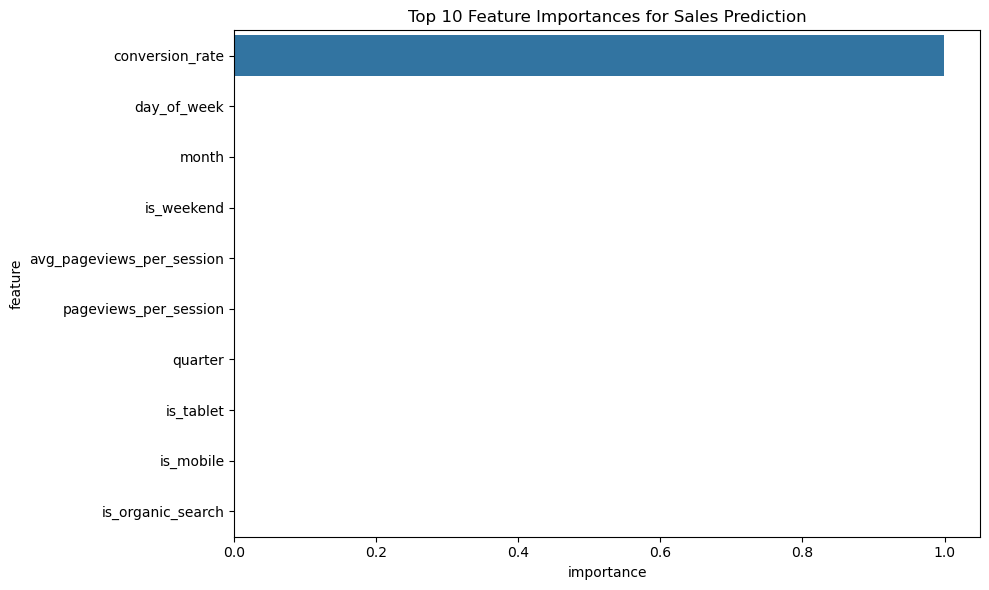

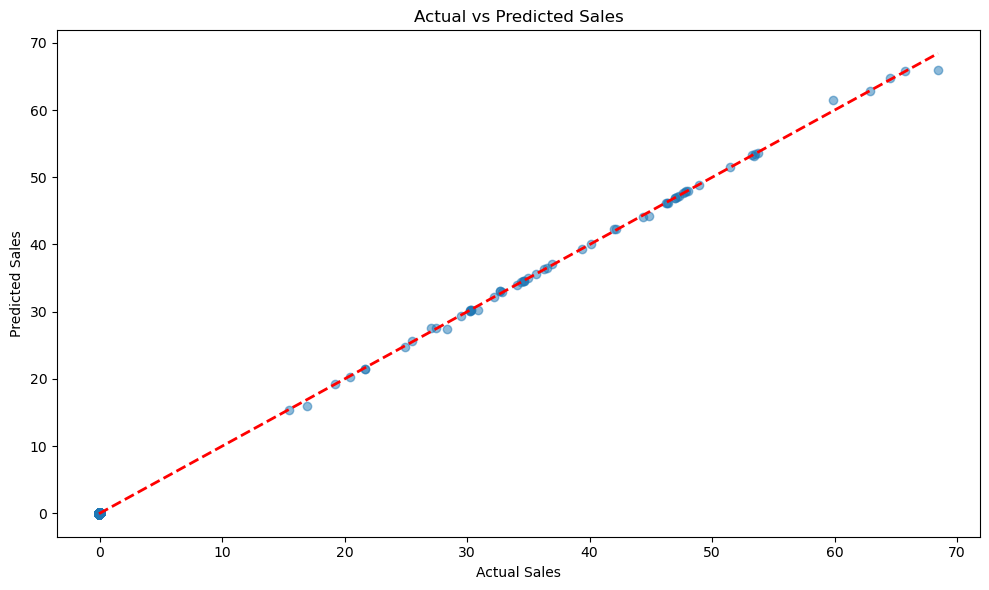

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_engineered_features(file_path='engineered_features.csv'):
    logger.info("Loading engineered features...")
    df = pd.read_csv(file_path)
    logger.info(f"Loaded data shape: {df.shape}")
    return df

def prepare_data_for_sales_prediction(df):
    logger.info("Preparing data for sales prediction...")
    
    if 'totals_transactions' not in df.columns:
        raise ValueError("Column 'totals_transactions' not found in the dataset")
    
    # Select features relevant for sales prediction
    features = ['pageviews_per_session', 'is_bounce', 'is_mobile', 'is_tablet', 'is_desktop',
                'is_organic_search', 'is_paid_search', 'is_referral', 'is_us', 'avg_pageviews_per_session',
                'conversion_rate', 'day_of_week', 'is_weekend', 'month', 'quarter']
    
    # Ensure all selected features are present in the dataframe
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"The following features are missing from the dataframe: {missing_features}")
    
    X = df[features]
    y = df['totals_transactions']
    
    logger.info(f"Features used for sales prediction: {features}")
    logger.info(f"Target variable: totals_transactions")
    
    return X, y

def split_data(X, y, test_size=0.2, random_state=42):
    logger.info("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    logger.info(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):
    logger.info("Training Random Forest Regressor for sales prediction...")
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    logger.info("Sales prediction model training completed")
    return model

def evaluate_model(model, X_test, y_test):
    logger.info("Evaluating sales prediction model performance...")
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    logger.info(f"Mean Squared Error: {mse}")
    logger.info(f"Root Mean Squared Error: {rmse}")
    logger.info(f"Mean Absolute Error: {mae}")
    logger.info(f"R-squared Score: {r2}")
    return y_pred, mse, rmse, mae, r2

def interpret_results(model, X):
    logger.info("Interpreting sales prediction model results...")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    logger.info("Top 10 important features for sales prediction:")
    logger.info(feature_importance.head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importances for Sales Prediction')
    plt.tight_layout()
    plt.savefig('sales_feature_importances.png')
    logger.info("Sales feature importance plot saved as 'sales_feature_importances.png'")

def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title('Actual vs Predicted Sales')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted_sales.png')
    logger.info("Actual vs Predicted Sales plot saved as 'actual_vs_predicted_sales.png'")

if __name__ == "__main__":
    try:
        df = load_engineered_features()
        X, y = prepare_data_for_sales_prediction(df)
        X_train, X_test, y_train, y_test = split_data(X, y)
        model = train_model(X_train, y_train)
        y_pred, mse, rmse, mae, r2 = evaluate_model(model, X_test, y_test)
        interpret_results(model, X)
        plot_actual_vs_predicted(y_test, y_pred)
        logger.info("Sales prediction analysis completed successfully.")
    except Exception as e:
        logger.error(f"An error occurred during the sales prediction analysis: {str(e)}")